In [20]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('default')
from metrics import accuracy

from sklearn import datasets
from sklearn.model_selection import train_test_split

# Curse of Dimensionality
Many datasets have thousands or even millions of features per training instance - Using all of them will likely slow down your training.     
Consider that:     
Some of the features may not even add much information and could be discarded or ignored.     
Other features may be so highly correlated that you might be able to merge them into one and lose little information.     
   
Furthermore, most people can readily understand 3 dimensions but begin to struggle with 4 dimensions, let alone thousands.    

Other particularities of high dimensional data:
* In a unit square (1x1) points are unlikely to be extreme along any dimension whereas in a high dimensional space (eg. 10.000 dims) most points lay along the border of their spaces hypercube.
* high-dimensional datasets are at risk of being sparse, eg. the average distance between 2 points in a 3D unit square is 0.66, in a 10.000 dim space the average distance is around 408,25. 

In theory, you could increase the amount of training data to counter the sparseness of high dimensionality.
Because however the number of training instances required for a given density grows exponentially with the number of features, this is unrealistic.
As an example, for an average distance of 0.1 between points with 100 dimensions you would require more than the "number of atoms in our observable universe" (Aurelien Géron)

## Main approaches to dimensionality reduction
### Projection
In real-world datasets most points lie within a lower-dimensional subspace meaning you may not need the full set of features to get a good approximation of your data.

Projection essentially squasches higher dim points down onto a lower dimension. In some cases this works well because the higher dimensional data may already imitate the shape it would have in the lower dimension. In other cases such as the swiss toy roll dataset, different layers would be projected on top of each other, loosing valuable information in a lower dimension.


### Manifold Learning
Manifold - a shape in a lower dimensionality that has been twisted in a higher dimension. (TODO put images here for better visualization)
(example of this the toy roll dataset)

Manifold hypothesis: Most real-world high-dimensional data lie close to a much lower dimensional manifold. This assumptions is very often empirically observed.

**As a note:**\
While dimensionality will always speed up training it will not always improve the predictions. In some cases the decision boundary will be less complex in higher dimesions whereas in others it will be so in smaller dimensions. That is why before using dimensionality reduction, a model should first be tested on the full set of features.

# PCA: Principal Component Analysis

PCA reduces dimesionality by identifying the hyperplane that is closest to the data and then projects the data onto this hyperplane.
You can think of chosing the best hyperplane in 2 ways:
* Preserving the data's variance as it is projected into a lower dimension. (In essence loosing as little information as possible.)
* Minimizing the mean squared distance between the higher dimension points and their lower dimension counterparts.

PCA identifies the axis that accounts for the most amount of variance, then orthoganally the axis that accounts for the second most remaining amount of variance, then a 3rd axis that is orthogonal and so on.\
These axes are represented by unit vectors - the ith unit vector is called the **ith Principal Component**.\

**Note:** PCA supposes that the data is centered.

### How do you get the principal components?
2 ways to get the principal components:
1. Using the Covariance 
2. Using SVD 

[Read more about the differences between the 2 methods](https://jonathan-hui.medium.com/machine-learning-singular-value-decomposition-svd-principal-component-analysis-pca-1d45e885e491)

#### 1. Covariance method
Compute the Covariance = $B^T \cdot B$.\
Then compute the eigenvectors and values of the resulting covariance matrix.
Sort them in descending order/ descending importance and chose the top k dimensions.
Project the data to these dimensions with a dot-product.

#### 2. SVD method
With a standard matrix factorization like SVD - Singular Value Decomposition.\
<img src="https://miro.medium.com/v2/resize:fit:894/1*XNWUlrQJXGeoCDqUMd0iUA.png" height="200" />\
[Read more about SVD here](https://mukundh-murthy.medium.com/a-beginners-guide-to-singular-value-decomposition-svd-97581e080c11) or
[Watch the breakdown of SVD here](https://www.youtube.com/watch?v=nbBvuuNVfco)

To project the training set down onto a lower dimension hyperplane simply chose the number of principle components and compute the dot product of the training data X and the matrix W containing i principle components.

It can be useful to add a variable that tracks how much variance is explained by each principal component. This can help you decide how many components to use as there will generally be a drop off of variance at some principle component. For example, you may decide that you want your lower dimension representation of the data to still contain 95% of the variance of the original data. In that case you should chose the number of principle components that are able to achieve this. If your 1st principle component catches 80% of the variance, the second 10% and the 3rd 5% then you would only need the top 3 principle components to preserve 95% of the data's variance.\

### PCA for Compression

Using the the top i Principal Components that result in a preservation of 95% variance can greatly reduce the size of the dataset.\
For example the MNIST dataset of digits would thus be reduced down to 150 features in comparison to its original 784 features. This is a reduction of the dataset down to 20% of its original size. 

To return to the original dimensionality / decompress, the inverse of the PCA transformation can be applied ($X_{proj} \cdot W_d^T$). This will result in the original sized dataset with a slight loss of information (somewhere in the range of the variance that you give up in the first steps). In MNIST this leads to slightly lower quality images that still show the digits quite clearly.

### Incremental PCA
TODO

In [21]:
class PCA:
    def __init__(self, n_components):
        self.n_components = n_components
        self.components = None
        self.mean = None

    def fit(self, X):
        self.mean = np.mean(X, axis=0)
        centered_X = X - self.mean
        
        # get the covariance matrix and its eigenvalues /-vectors
        cov_X =  np.cov(centered_X.T)
        eigenvalues, eigenvectors = np.linalg.eig(cov_X)
        eigenvectors = eigenvectors.T

        # sort the eigenvalues in descending order
        ids = np.argsort(eigenvalues)[::-1]
        eigenvalues = eigenvalues[ids]
        eigenvectors = eigenvectors[ids]

        self.components = eigenvectors[0:self.n_components]


    def transform(self, X):
        centered_X = X - self.mean
        return np.dot(centered_X, self.components.T)


In [22]:
iris_data = datasets.load_iris()
X = iris_data.data
y = iris_data.target

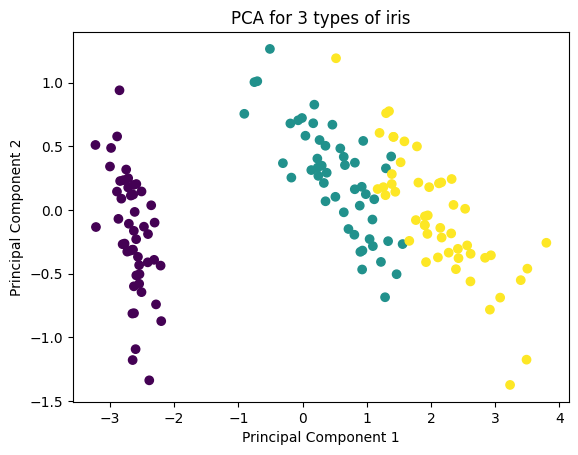

In [56]:
iris_pca = PCA(2)

iris_pca.fit(X)
projected = iris_pca.transform(X)

plt.scatter(projected[:,0], projected[:,1], c=y)
plt.title("PCA for 3 types of iris")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show()

In [66]:
class PCA_svd:
    def __init__(self, n_components):
        self.n_components = n_components
        self.components = None
        self.mean = None
        self.U = None

    def fit(self, X):
        self.mean = np.mean(X, axis=0)
        centered_X = X - self.mean
        
        # get the covariance matrix and its eigenvalues /-vectors
        self.U, S, V = np.linalg.svd(X)
        self.components = S[0:self.n_components]

    def transform(self, X):
        centered_X = X - self.mean
        return np.dot(centered_X, self.components.T)

In [67]:
iris_pca_svd = PCA_svd(2)

iris_pca_svd.fit(X)
projected_svd = iris_pca_svd.transform(X)

plt.scatter(projected_svd[:,0], projected_svd[:,1], c=y)
plt.title("PCA for 3 types of iris")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show()


ValueError: operands could not be broadcast together with shapes (150,150) (4,) 